<a href="https://colab.research.google.com/github/AzureAmber/STAT-390-Covid-Project/blob/ericazhang/Models/erica/lstm/6_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# These two lines avoid dead kernel after importing keras
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import keras

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
import time as time
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_nn.csv', parse_dates = ['date'])
train = train.drop(['continent', 'G20', 'G24'], axis = 1)
test = pd.read_csv('test_nn.csv', parse_dates = ['date'])
test = test.drop(['continent', 'G20', 'G24'], axis = 1)

print(train.shape)
print(test.shape)

(24771, 34)
(5900, 34)


# Pre-processing

In [4]:
# encode non-numeric features

days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train['day_of_week'] = train['day_of_week'].map(days)
test['day_of_week'] = test['day_of_week'].map(days)

indicator_columns = ['total_tests_b', 'new_tests_b', 'positive_rate_b', 'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']

# Convert indicator variables to numeric: True to 1 and False to 0
for col in indicator_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)


In [5]:
# add one-wk lag for new_cases

def add_lagged_features(df, target, lag_periods):
    lagged_df = df[[target]].shift(lag_periods)
    lagged_df.columns = [f'lag{lag_periods}_' + target]
    existing_lagged_col = f'lag{lag_periods}_' + target
    if existing_lagged_col in df.columns:
        df = df.drop(columns=[existing_lagged_col])
    df_with_lags = df.join(lagged_df)
    return df_with_lags.fillna(0)

train_with_lags = add_lagged_features(train, 'new_cases', 7)
test_with_lags = add_lagged_features(test, 'new_cases', 7)

In [6]:
# normalize on country-level

def normalize(df, group_col, target_col, indicators, non_numeric,):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_normalize = numeric_cols.difference([target_col] + indicators + non_numeric)

    df_normalized = df.copy()
    for col in cols_to_normalize:
        # Apply normalization within each region for the column
        df_normalized[col] = df.groupby(group_col)[col].transform(lambda x: (x - x.mean()) / x.std())

    df_normalized = df_normalized.fillna(0)
    return df_normalized

# List of indicator columns and non-numeric columns
indicators = ['total_tests_b', 'new_tests_b', 'positive_rate_b',
              'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']
non_numeric = ['date', 'location', 'day_of_week', 'month']

# Apply the normalize function to your train and test sets
train_normalized = normalize(train_with_lags, 'location', 'new_cases', indicators, non_numeric)
test_normalized = normalize(test_with_lags, 'location', 'new_cases', indicators, non_numeric)


#train_encoded = pd.get_dummies(train_normalized, columns=['location'])
#test_encoded = pd.get_dummies(test_normalized, columns=['location'])

In [7]:
data=pd.concat([train_normalized, test_normalized])

data.set_index('date', inplace = True)

# select out region of interest
US_data = data.loc[data.location == 'United States'].drop(columns = ['location']).astype(float)

US_data.head(10)

#normalize target variable too
normalized_y = (US_data['new_cases'] - US_data['new_cases'].min()) / (US_data['new_cases'].max() - US_data['new_cases'].min())

min_value = US_data['new_cases'].min()
max_value = US_data['new_cases'].max()

US_data['new_cases'] = normalized_y

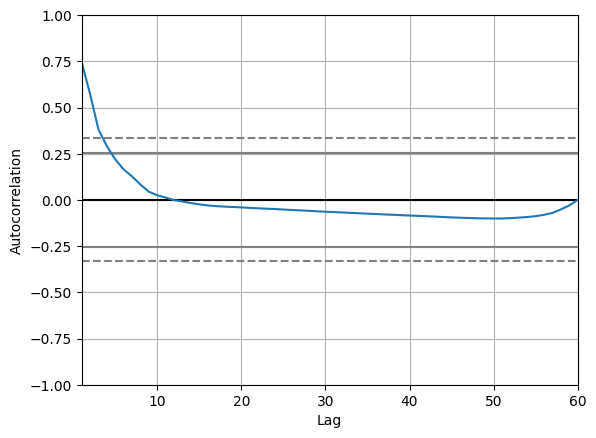

In [8]:
# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(US_data['new_cases'].iloc[:60])
plt.show()

# 14 looks like a reasonable lag to capture bi-weekly seasonality

In [9]:
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop(['new_cases'], axis=1).values))
    return series

series=make_series(US_data)
print(series[0][0], series[0][1].shape, series[0][2].shape)
US_train = series[:(US_data.loc[US_data.index < '2023-01-01'].shape[0]-13)]
US_test = series[(US_data.loc[US_data.index < '2023-01-01'].shape[0]-13):]

2020-02-02 00:00:00 () (14, 32)


# Training

In [10]:
def create_model(sequence_length, feature_size, learning_rate):

    inputs = Input(shape=(sequence_length, feature_size))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    return model

In [11]:
# Create the LSTM model
lstm_model = create_model(14, 32, 0.02)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 32)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 8353 (32.63 KB)
Trainable params: 8353 (32.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
x=np.array([x[2].reshape(14,32)for x in US_train])
y=np.array([x[1] for x in US_train])

print(x.shape)
print(y.shape)

history = lstm_model.fit(
    x=x,y=y,
    epochs= 200,
    batch_size= 32,
    shuffle=False,
)

(1064, 14, 32)
(1064,)
Epoch 1/200
34/34 [==============================] - 2s 5ms/step - loss: 0.0875
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 12/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 13/200
3

In [14]:
US_train_pred = pd.DataFrame(lstm_model.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_pred = pd.DataFrame(lstm_model.predict(np.array([x[2].reshape(14,32) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test])

US_train_pred = (US_train_pred * (max_value - min_value)) + min_value
US_test_pred = (US_test_pred * (max_value - min_value)) + min_value

8/8 [==============================] - 0s 2ms/step


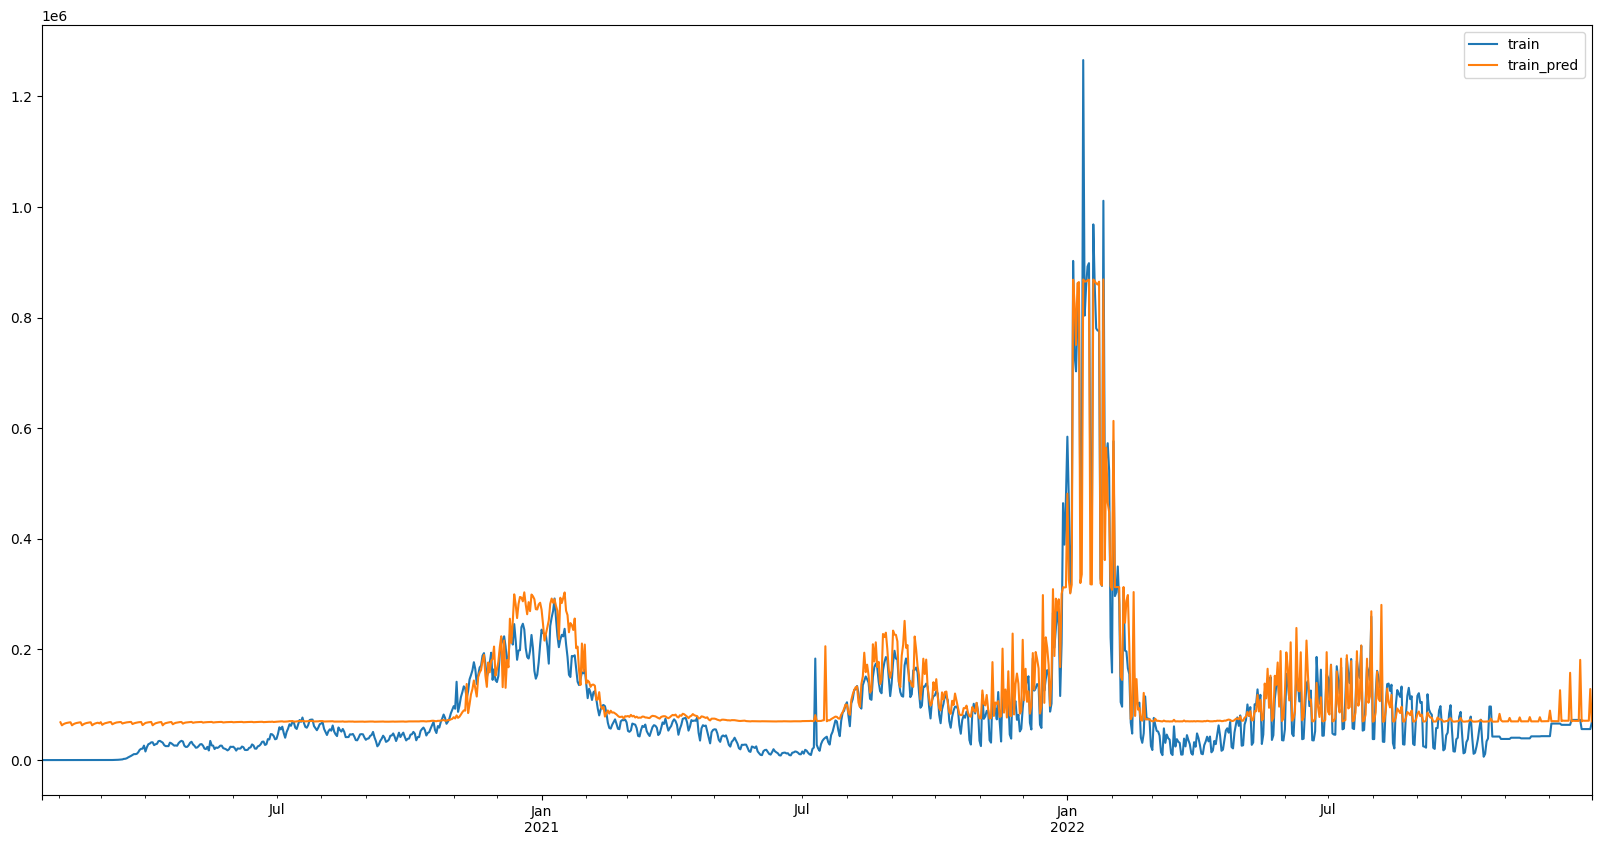

In [15]:
# plotting the training data
y_train_actual = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual, US_train_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

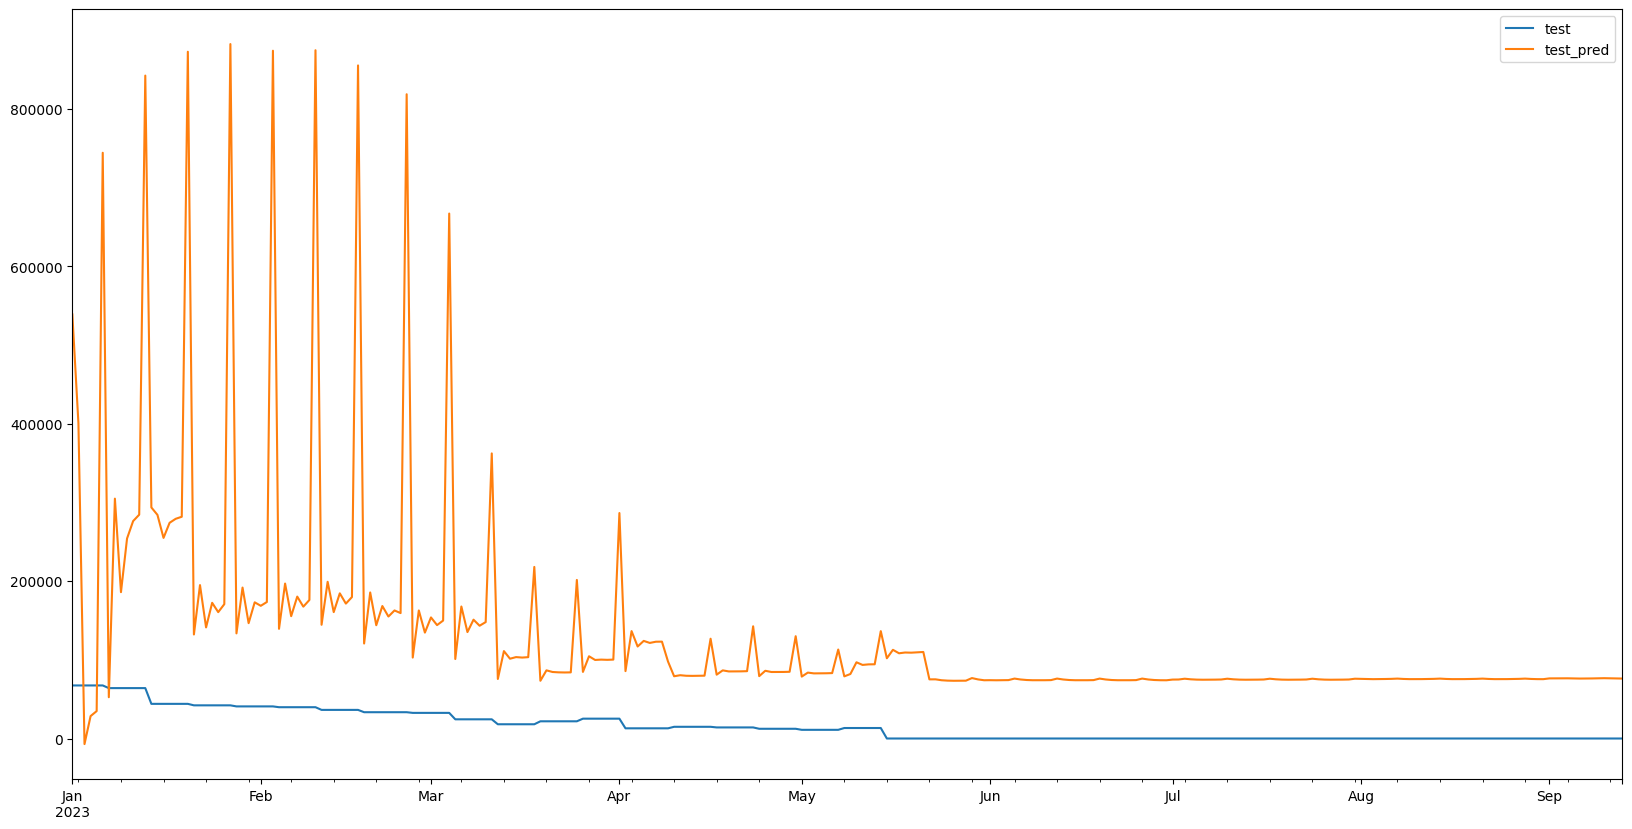

In [16]:
# plottting the testing data
y_test_actual = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual, US_test_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [17]:
print("The rmse on the US training data is", mean_squared_error(y_train_actual[13:], US_train_pred['yhat'], squared = False))
print("The rmse on the US testing data is", mean_squared_error(y_test_actual, US_test_pred['yhat'], squared = False))

The rmse on the US training data is 44482.101553807785
The rmse on the US testing data is 181777.27100505022


It seems to fit training data ok but not too good for testing data. So we will now tune the hyperparameter to see if model performance can be improved.


# Tuning Hyperparameters

In [18]:
import itertools

learning_rate = [0.01, 0.02, 0.05]
epochs = [100, 200, 300]
batch_size =[16, 32, 64]
combination = list(itertools.product(learning_rate, epochs, batch_size))
combination

[(0.01, 100, 16),
 (0.01, 100, 32),
 (0.01, 100, 64),
 (0.01, 200, 16),
 (0.01, 200, 32),
 (0.01, 200, 64),
 (0.01, 300, 16),
 (0.01, 300, 32),
 (0.01, 300, 64),
 (0.02, 100, 16),
 (0.02, 100, 32),
 (0.02, 100, 64),
 (0.02, 200, 16),
 (0.02, 200, 32),
 (0.02, 200, 64),
 (0.02, 300, 16),
 (0.02, 300, 32),
 (0.02, 300, 64),
 (0.05, 100, 16),
 (0.05, 100, 32),
 (0.05, 100, 64),
 (0.05, 200, 16),
 (0.05, 200, 32),
 (0.05, 200, 64),
 (0.05, 300, 16),
 (0.05, 300, 32),
 (0.05, 300, 64)]

In [ ]:
rmse_list = []
combination_list = []
x=np.array([x[2].reshape(14,32) for x in US_train])
y=np.array([x[1] for x in US_train])
for comb in combination:
    learning_rate = comb[0]
    epochs = comb[1]
    batch_size = comb[2]
    # initialize model
    inputs = Input(shape=(14,32))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model_tuned = Model(inputs=inputs, outputs=outputs)
    model_tuned.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    history = model_tuned.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
)
    US_train_pred_tuned=pd.DataFrame(model_tuned.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
    rmse = mean_squared_error(y_train_actual[13:], US_train_pred_tuned['yhat'], squared = False)
    rmse_list.append(rmse)
    combination_list.append(comb)

In [20]:
results = pd.DataFrame(index = combination_list, data = rmse_list, columns = ['rmse'])
results.reset_index(inplace = True)
results.sort_values(by = 'rmse', ascending = True).iloc[0,0]

(0.01, 100, 16)

In [21]:
results.sort_values(by = 'rmse', ascending = True)

,index,rmse
0,"(0.01, 100, 16)",155604.954690
1,"(0.01, 100, 32)",155604.966844
6,"(0.01, 300, 16)",155604.981091
26,"(0.05, 300, 64)",155604.983582
17,"(0.02, 300, 64)",155604.987702
13,"(0.02, 200, 32)",155604.990476
12,"(0.02, 200, 16)",155604.992646
9,"(0.02, 100, 16)",155604.998043
15,"(0.02, 300, 16)",155604.998678
8,"(0.01, 300, 64)",155605.000422


In [22]:
# tuned model
learning_rate = 0.01
batch_size = 16
epochs = 100
sequence_length = 14
inputs = Input(shape=(14,32))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)
model_best = Model(inputs=inputs, outputs=outputs)
model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
x=np.array([x[2].reshape(14,32) for x in US_train])
y=np.array([x[1] for x in US_train])
print(x.shape)
print(y.shape)
history_best = model_best.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
)


(1064, 14, 32)
(1064,)
Epoch 1/100
67/67 [==============================] - 2s 4ms/step - loss: 0.0404
Epoch 2/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 3/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 4/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 5/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 7/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 8/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 9/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 10/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 12/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 13/100
6

In [23]:
US_train_best_pred = pd.DataFrame(model_best.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_best_pred = pd.DataFrame(model_best.predict(np.array([x[2].reshape(14,32) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test ])

US_train_best_pred = (US_train_best_pred * (max_value - min_value)) + min_value
US_test_best_pred = (US_test_best_pred * (max_value - min_value)) + min_value

8/8 [==============================] - 0s 2ms/step


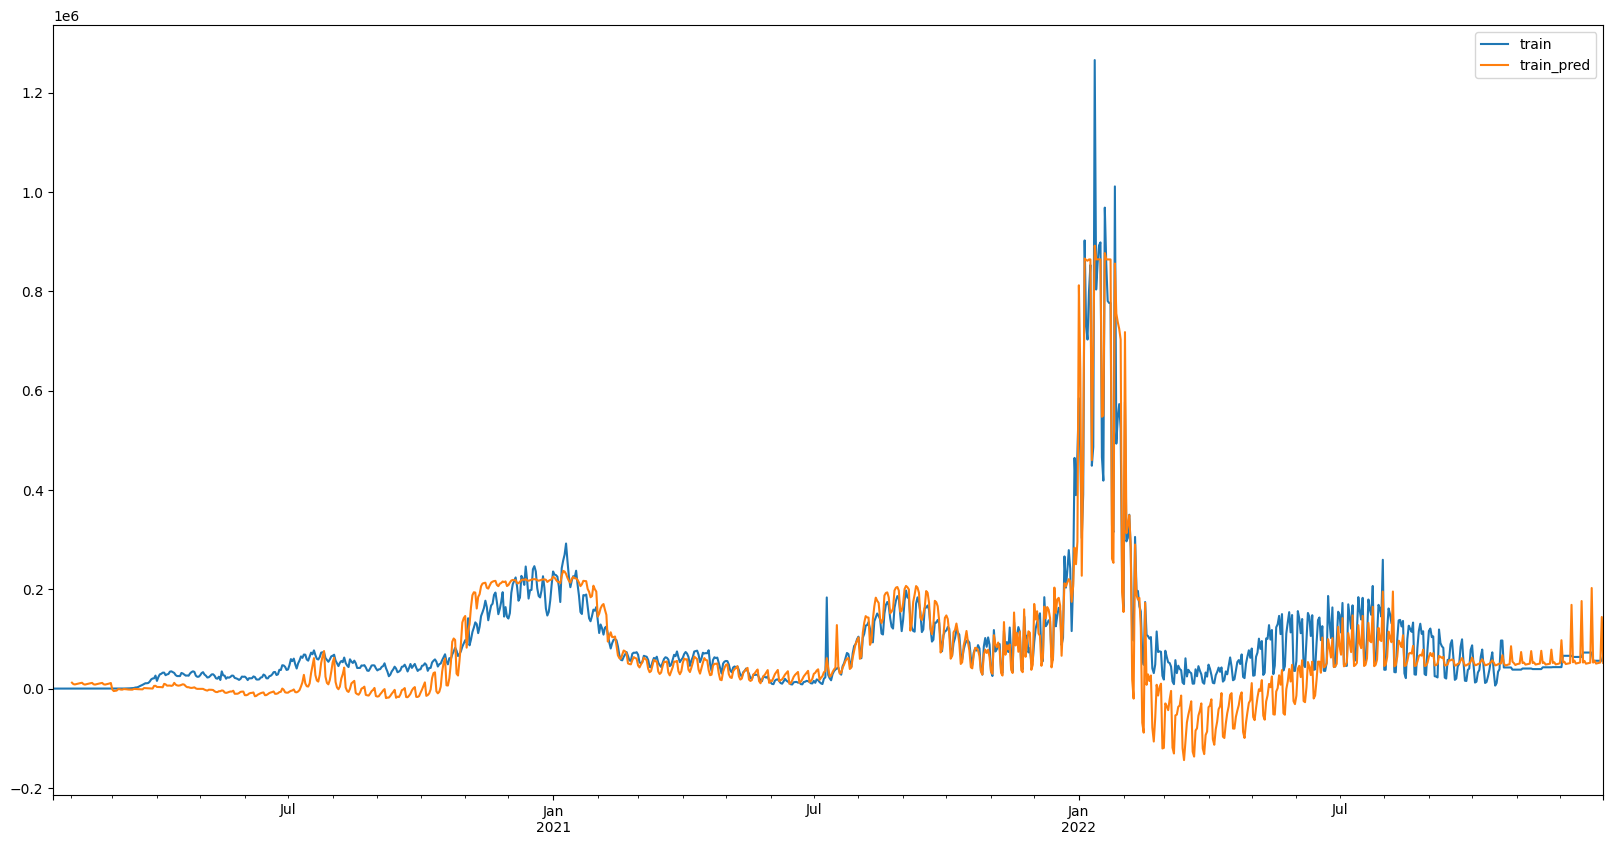

In [36]:
# plotting the training data

y_train_actual_best = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual_best.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual_best, US_train_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])
plt.savefig('US_training_data_plot.jpeg')


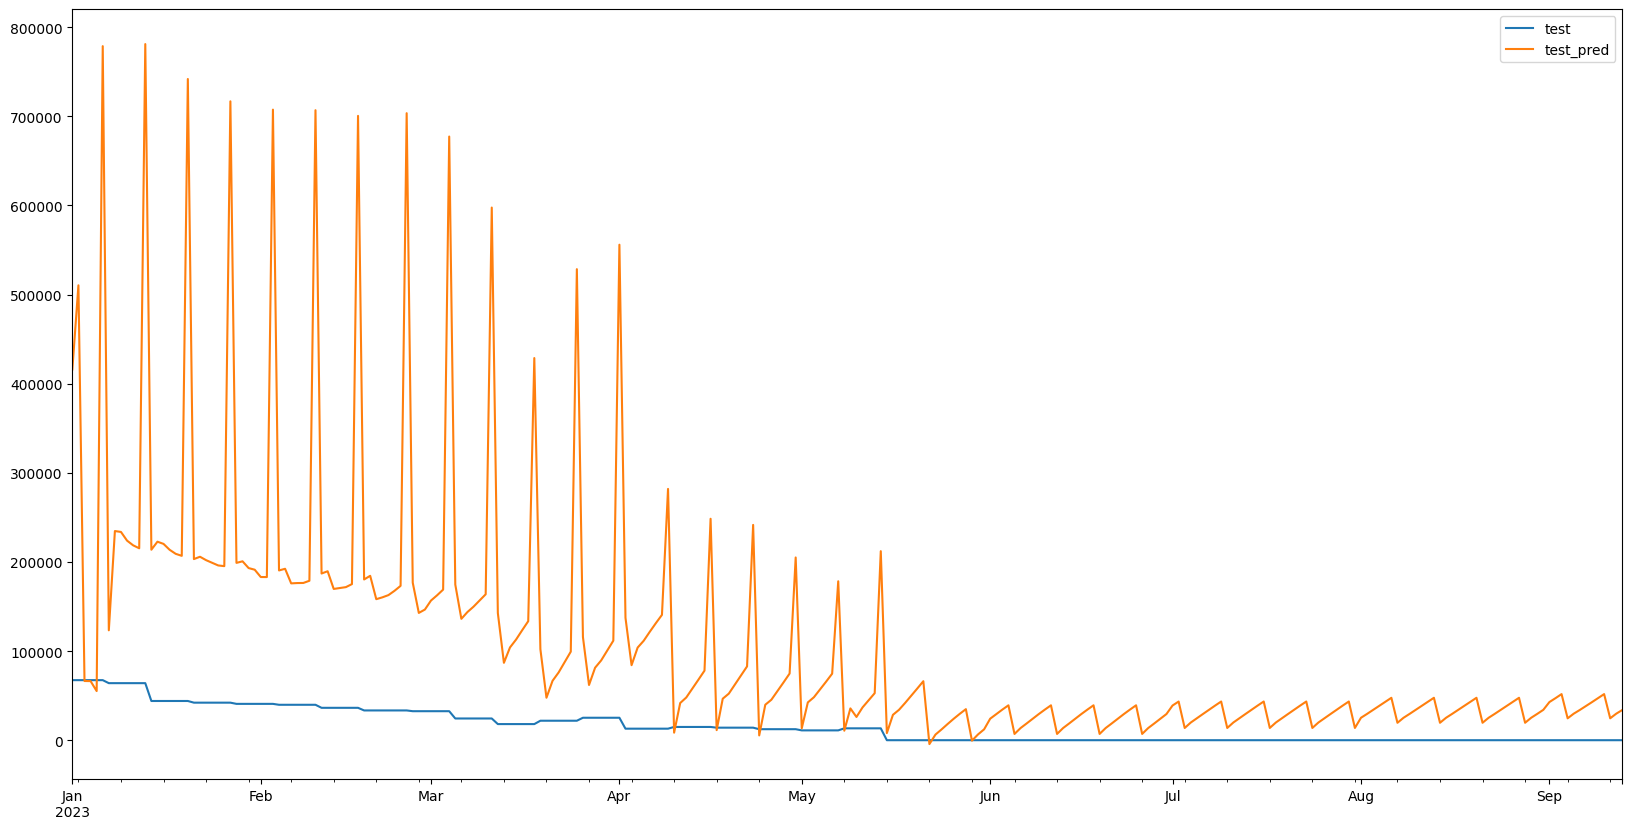

In [37]:
# plottting the testing data
y_test_actual_best = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual_best.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual_best, US_test_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])
plt.savefig('US_testing_data_plot.jpeg')

In [27]:
print("The rmse on the US training data is", mean_squared_error(y_train_actual_best[13:], US_train_best_pred['yhat'], squared = False))
print("The rmse on the US testing data is", mean_squared_error(y_test_actual_best, US_test_best_pred['yhat'], squared = False))

The rmse on the US training data is 51475.70121822742
The rmse on the US testing data is 169216.6100896368


Overfitting training data but still not too bad result - slight improvement from manual combo. If have time, should try log transform y rather than normalize it.

# Fitting whole dataset

In [28]:
# define make series again
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop('new_cases', axis=1).values))
    return series

In [ ]:
rmse_results = []
loc_list = list(train_normalized.location.unique())

for loc in loc_list:

    loc_data = data[data['location'] == loc]
    loc_data = data.loc[data.location == loc].drop(columns = ['location']).astype(float)

    #normalize target variable
    min_value = loc_data['new_cases'].min()
    max_value = loc_data['new_cases'].max()
    loc_data['new_cases'] = (loc_data['new_cases'] - min_value) / (max_value - min_value)

    #feed into series
    series=make_series(loc_data)
    loc_train = series[:(loc_data.loc[loc_data.index < '2023-01-01'].shape[0]-13)]
    loc_test = series[(loc_data.loc[loc_data.index < '2023-01-01'].shape[0]-13):]

    #fit the model
    learning_rate = 0.01
    batch_size = 16
    epochs = 100
    sequence_length = 14
    inputs = Input(shape=(14,32))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model2 = Model(inputs=inputs, outputs=outputs)
    model2.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    x=np.array([x[2].reshape(14,32) for x in loc_train])
    y=np.array([x[1] for x in loc_train])
    history2 = model2.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False)

    #predict train and test

    loc_train_pred = pd.DataFrame(model2.predict(x), columns=['yhat'], index=[x[0] for x in loc_train])
    loc_test_pred = pd.DataFrame(model2.predict(np.array([x[2].reshape(14,32) for x in loc_test])), columns=['yhat'], index=[x[0] for x in loc_test ])

    #denormalize train and test
    loc_train_pred = (loc_train_pred * (max_value - min_value)) + min_value
    loc_test_pred = (loc_test_pred * (max_value - min_value)) + min_value


    y_train2 = train_normalized.loc[train_normalized.location == loc, 'new_cases']
    y_train2.index = train_normalized.loc[train_normalized.location == loc, 'date']

    y_test2 = test_normalized.loc[test_normalized.location == loc, 'new_cases']
    y_test2.index = test_normalized.loc[test_normalized.location == loc, 'date']

    #calculate rmse

    train_rmse = mean_squared_error(y_train2[13:], loc_train_pred['yhat'], squared=False)
    test_rmse = mean_squared_error(y_test2, loc_test_pred['yhat'], squared=False)
    print(f"The RMSE on the {loc} training data is {train_rmse}")
    print(f"The RMSE on the {loc} testing data is {test_rmse}")

    # Append RMSE results to the list
    rmse_results.append([loc, train_rmse, test_rmse])

    # Plotting the training data
    train_plot = pd.concat([y_train2, loc_train_pred['yhat']], axis=1)
    train_plot.plot(figsize=(20,10))
    plt.legend(['train', 'train_pred'])
    plt.title(f"{loc} - Training Data")
    plt.savefig(f'{loc}_training_data_plot.jpeg')

    # Plotting the testing data
    test_plot = pd.concat([y_test2, loc_test_pred['yhat']], axis=1)
    test_plot.plot(figsize=(20,10))
    plt.legend(['test', 'test_pred'])
    plt.title(f"{loc} - Testing Data")
    plt.savefig(f'{loc}_testing_data_plot.jpeg')


In [41]:
# Convert RMSE results to a DataFrame and save as CSV
rmse_df = pd.DataFrame(rmse_results, columns=['Location', 'Train RMSE', 'Test RMSE'])
rmse_df.to_csv('lstm_rmse_results.csv', index=False)